In [1]:
import os
import json
import pickle

import pandas as pd
pd.options.display.max_colwidth = 200

import numpy as np
from numpy import mean
from collections import Counter
import re
import regex
import random

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer as CV
import string

exclude = set(string.punctuation)

## Load files

In [2]:
output_path = os.path.join(os.getcwd(), 'figures')

In [3]:
# extra metadata
martin_quinn = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'martin_quinn.csv'))
salience_df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'all_metadata.csv'))

/var/folders/lp/x4djrvvn0pg2br3sp0y85wkr0000gn/T/ipykernel_90528/465373169.py:3: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  salience_df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'all_metadata.csv'))


In [4]:
# load predictions
remove_per_curiam = False
if remove_per_curiam:
    input_path = os.path.join(os.getcwd(), 'predictions_no_percur_df.p')
    
else:
    input_path = os.path.join(os.getcwd(), 'scotus', 'output', 'combined_output')

In [5]:
input_path

'/Users/rosamondthalken/Documents/Projects/SupremeCourt/SupremeCourtPython/scotus/output/combined_output'

In [6]:
df = pd.read_pickle(input_path)

In [7]:
len(df.opinion_num.unique())

15291

In [8]:
df.groupby(["category"])

## Ratio of monologic to non-monologic by opinion type

In [9]:
def plot_ratio(df):
    sns.set(style='ticks', font_scale=2)
    sns.set_palette(sns.color_palette("colorblind"))
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]}
            
    plt.figure(figsize=(15,10))
    sns.barplot(data=df, 
                x="category", 
                y="monologic_prediction",
                estimator=mean,
                hue = "category",
                order=["Majority","Per Curiam", "Dissenting", "Concurring"],
                palette = palette,
                dodge=False
               )

    plt.xlabel('Category', fontsize = 30)
    plt.ylabel('Monologic Fraction', fontsize = 30)
    sns.despine()
    plt.legend([],[], frameon=False)
    plt.savefig(output_path + '/by_opinion', dpi = 300)
    plt.show()

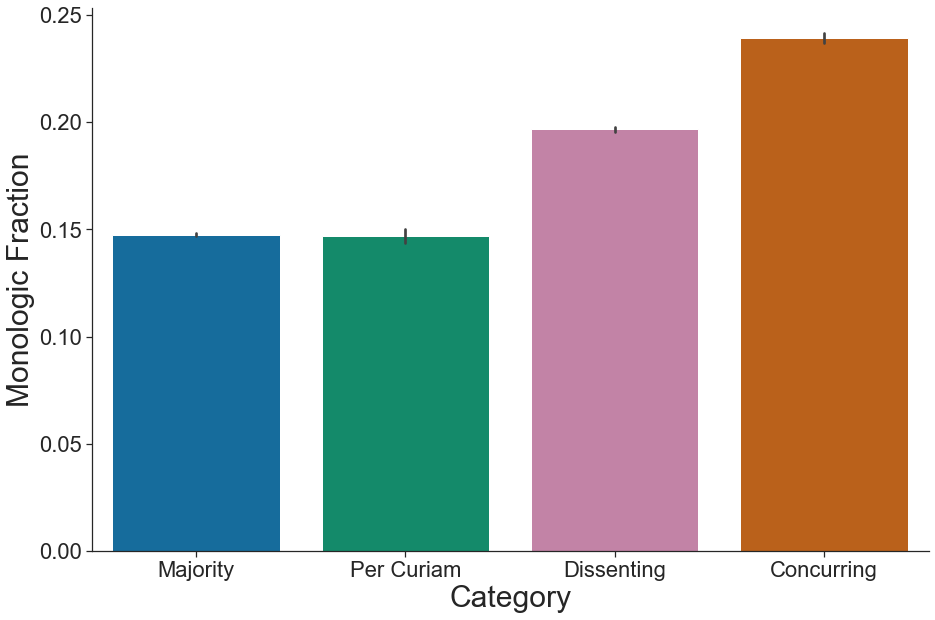

In [10]:
plot_ratio(df)

## Changes in monologic voice over the course of the opinion

In [19]:
def create_all_bins(df, bin_size, labels = True):
    if labels:
        df['bins'] = pd.cut(df["sent_location"], bin_size, labels = np.arange(0, bin_size, 1))
    
    else:
        df['bins'] = pd.cut(df["sent_location"], bin_size)
    mean_df = df[['bins', 'monologic_prediction']].groupby('bins').mean()
    mean_df['bins'] = mean_df.index
    
    return mean_df

In [20]:
def plot_sentences_by_opinion_type(df, bin_size):
    sns.set_palette(sns.color_palette("colorblind"))
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 

  # NOTE: create_all_bins is a function created outside of this function
    category_prediction_bins = df.groupby('category').apply(create_all_bins, bin_size)
    category_prediction_bins["category"] = category_prediction_bins.index.get_level_values(0)

    g = sns.FacetGrid(category_prediction_bins, 
                      col="category", 
                      col_wrap=2, 
                      hue = "category", 
                      height=5, 
                      col_order = ["Majority", "Per Curiam", "Dissenting", "Concurring"],
                      palette=palette)
    g.map(sns.barplot, "bins", "monologic_prediction")
    g.set_titles(col_template="{col_name}", size = 20)
    g.set(xticklabels=[])
    g.set_axis_labels("", "")
    plt.subplots_adjust(hspace=0.4)
    plt.text(-4.5, -.06, 'Opinion Time', fontsize = 20)
    plt.text(-28, .45, 'Monologic Fraction', rotation=90,  fontsize = 20)
    g.fig.subplots_adjust(top=0.88)
    plt.savefig(output_path + '/over_case_time_category', dpi = 300)

/Users/rosamondthalken/opt/anaconda3/envs/3350/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


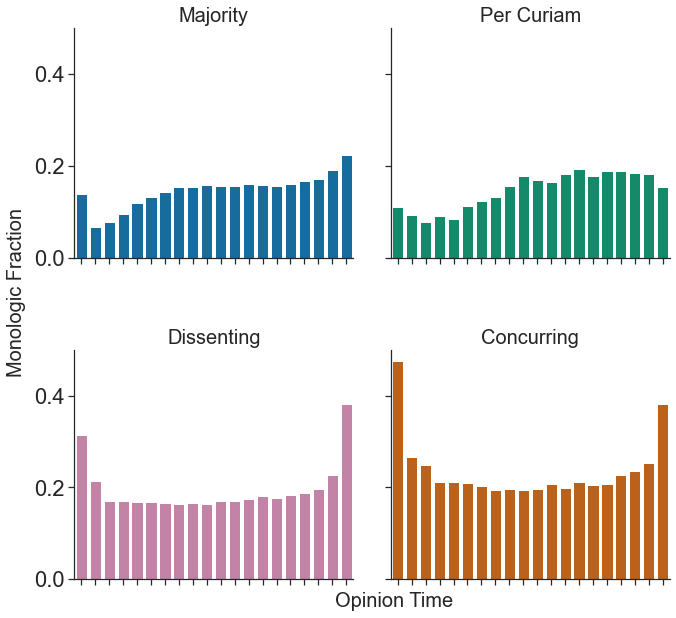

In [21]:
plot_sentences_by_opinion_type(df, 20)

## Monologic voice changes over years

In [16]:
def plot_sentences_over_years(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(14,5))
    graph = sns.lineplot(data=df,
                x="year", 
                y="monologic_prediction",
                estimator=mean, 
                color='#007273')
    
    graph.set_facecolor('gainsboro')

    chief_years = [1946, 1953, 1969, 1986, 2005]
    chief_names = ["Vinson", "Warren", "Burger", "Rehnquist", "Roberts"]
    for y, n in zip(chief_years, chief_names):
        plt.axvline(y, color='0.8')
        plt.text(x=y+.5, y=.21, s=n, color='black')
    plt.xticks(np.arange(1945, 2022, 10))
    plt.xlabel('Case Year', labelpad=20, fontsize = 17)
    plt.ylabel('Monologic Concentration', labelpad=20, fontsize = 17)
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/over_time', dpi = 300)
    plt.show()

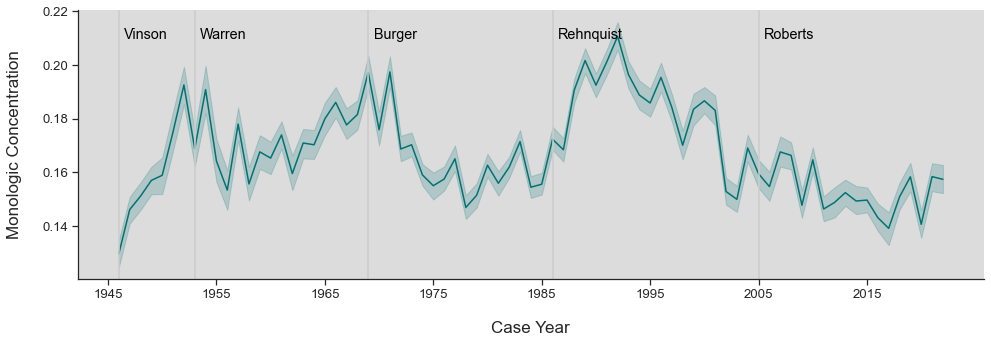

In [17]:
plot_sentences_over_years(df)

## Temporal trends by opinion type and author

In [24]:
author_by_year = df.groupby(['author','year', 'category'], as_index=False)['monologic_prediction'].mean()

In [25]:
def trends_over_years_by_author(df, year_col, prediction_col, category_col):
    sns.set(style='ticks', font_scale=2)
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 

    sns.lmplot(data=df, 
               x=year_col, 
               y=prediction_col, 
               hue=category_col, 
               palette = palette, 
               lowess = True, 
               height=8, 
               aspect=1.7, 
               scatter_kws={'alpha':0.3},
               line_kws={'lw': 4},
               legend = False)

    leg = plt.legend(title="", loc = 2)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.ylim(0, .5)
    plt.xlabel('Year', fontsize = 20)
    plt.ylabel('Monologic Fraction', fontsize = 20)
    plt.savefig(output_path + '/scatter_over_time', dpi = 300)
    plt.show()

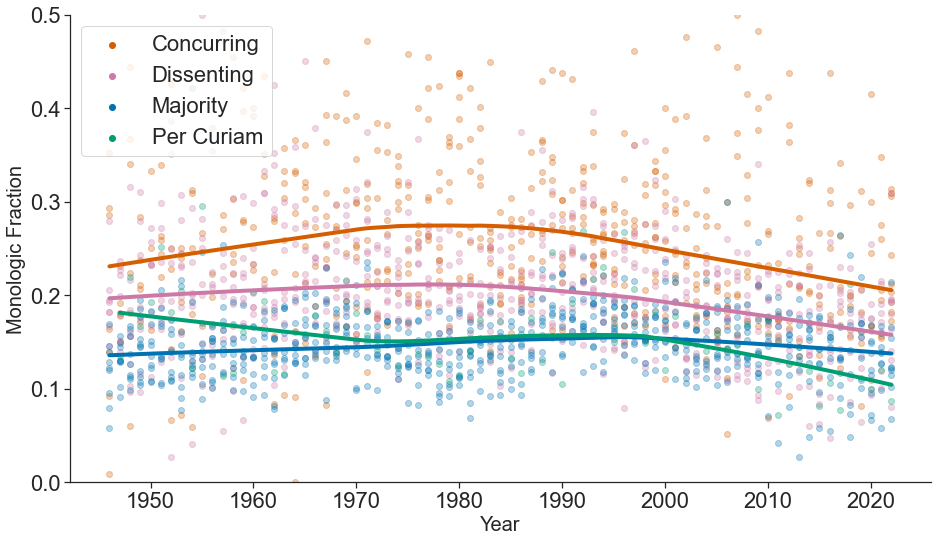

In [26]:
trends_over_years_by_author(author_by_year, "year", "monologic_prediction", "category")

In [27]:
roberts_court_df = df[df["chief_justice"] == "Roberts"]
rehnquist_court_df = df[df["chief_justice"] == "Rehnquist"]

In [28]:
frames = [roberts_court_df, rehnquist_court_df]
big_frame = pd.concat(frames)

In [29]:
rehn_rob_by_year = big_frame.groupby(['author','year', 'category'], as_index=False)['monologic_prediction'].mean()

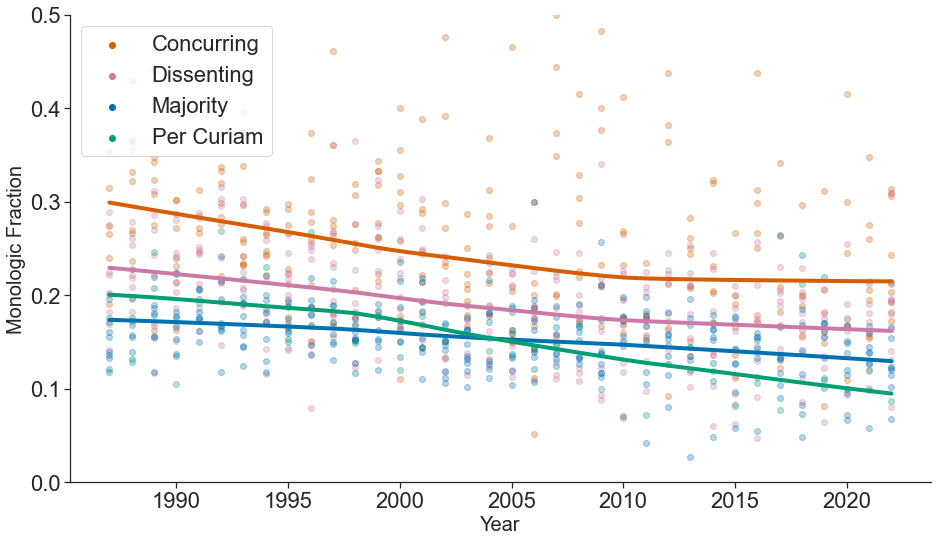

In [30]:
trends_over_years_by_author(rehn_rob_by_year, "year", "monologic_prediction", "category")

## Effect size between courts

In [31]:
per_opinion = df.groupby(['opinion_num', 'year'], as_index=False)['monologic_prediction'].mean()

In [32]:
# merge per opinion with metadata
vinson_court = per_opinion[per_opinion["year"] <= 1953]
warren_court = per_opinion[(per_opinion["year"] >= 1954) & (per_opinion["year"] <= 1968)]
burger_court = per_opinion[(per_opinion["year"] >= 1969) & (per_opinion["year"] <= 1985)]
rehnquist_court = per_opinion[(per_opinion["year"] >= 1986) & (per_opinion["year"] <= 2005)]
roberts_court = per_opinion[(per_opinion["year"] >= 2006)]

In [33]:
from statistics import mean, stdev
from math import sqrt

def cohens_d(values_1, values_2):
    cohens_d = (mean(values_1) - mean(values_2)) / (sqrt((stdev(values_1) ** 2 + stdev(values_2) ** 2) / 2))
    return cohens_d

In [34]:
print("Vinson <-> Warren: "+ str(cohens_d(warren_court["monologic_prediction"].to_list(), vinson_court["monologic_prediction"].to_list())))
print("Warren <-> Burger: "+ str(cohens_d(burger_court["monologic_prediction"].to_list(), warren_court["monologic_prediction"].to_list())))
print("Burger <-> Rehnquist: "+ str(cohens_d(rehnquist_court["monologic_prediction"].to_list(), burger_court["monologic_prediction"].to_list())))
print("Rehnquist <-> Roberts: "+ str(cohens_d(roberts_court["monologic_prediction"].to_list(), rehnquist_court["monologic_prediction"].to_list())))

Vinson <-> Warren: 0.14275968622194443
Warren <-> Burger: 0.04091692951273347
Burger <-> Rehnquist: 0.11566154027043876
Rehnquist <-> Roberts: -0.31248943024536896


## Percent of majority cases per year

In [35]:
unique_opinion_df = df[["opinion_num", "category", "year"]].drop_duplicates()
opinion_counts_year = unique_opinion_df.groupby(["category", "year"]).count()
opinion_counts_year = opinion_counts_year.reset_index()
yearly_total = pd.DataFrame(opinion_counts_year.groupby("year")["opinion_num"].sum()).reset_index()
full_counts_by_year = opinion_counts_year.merge(yearly_total, on = "year")
full_counts_by_year["percentage"] = full_counts_by_year['opinion_num_x']/full_counts_by_year['opinion_num_y']*100

/Users/rosamondthalken/opt/anaconda3/envs/3350/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


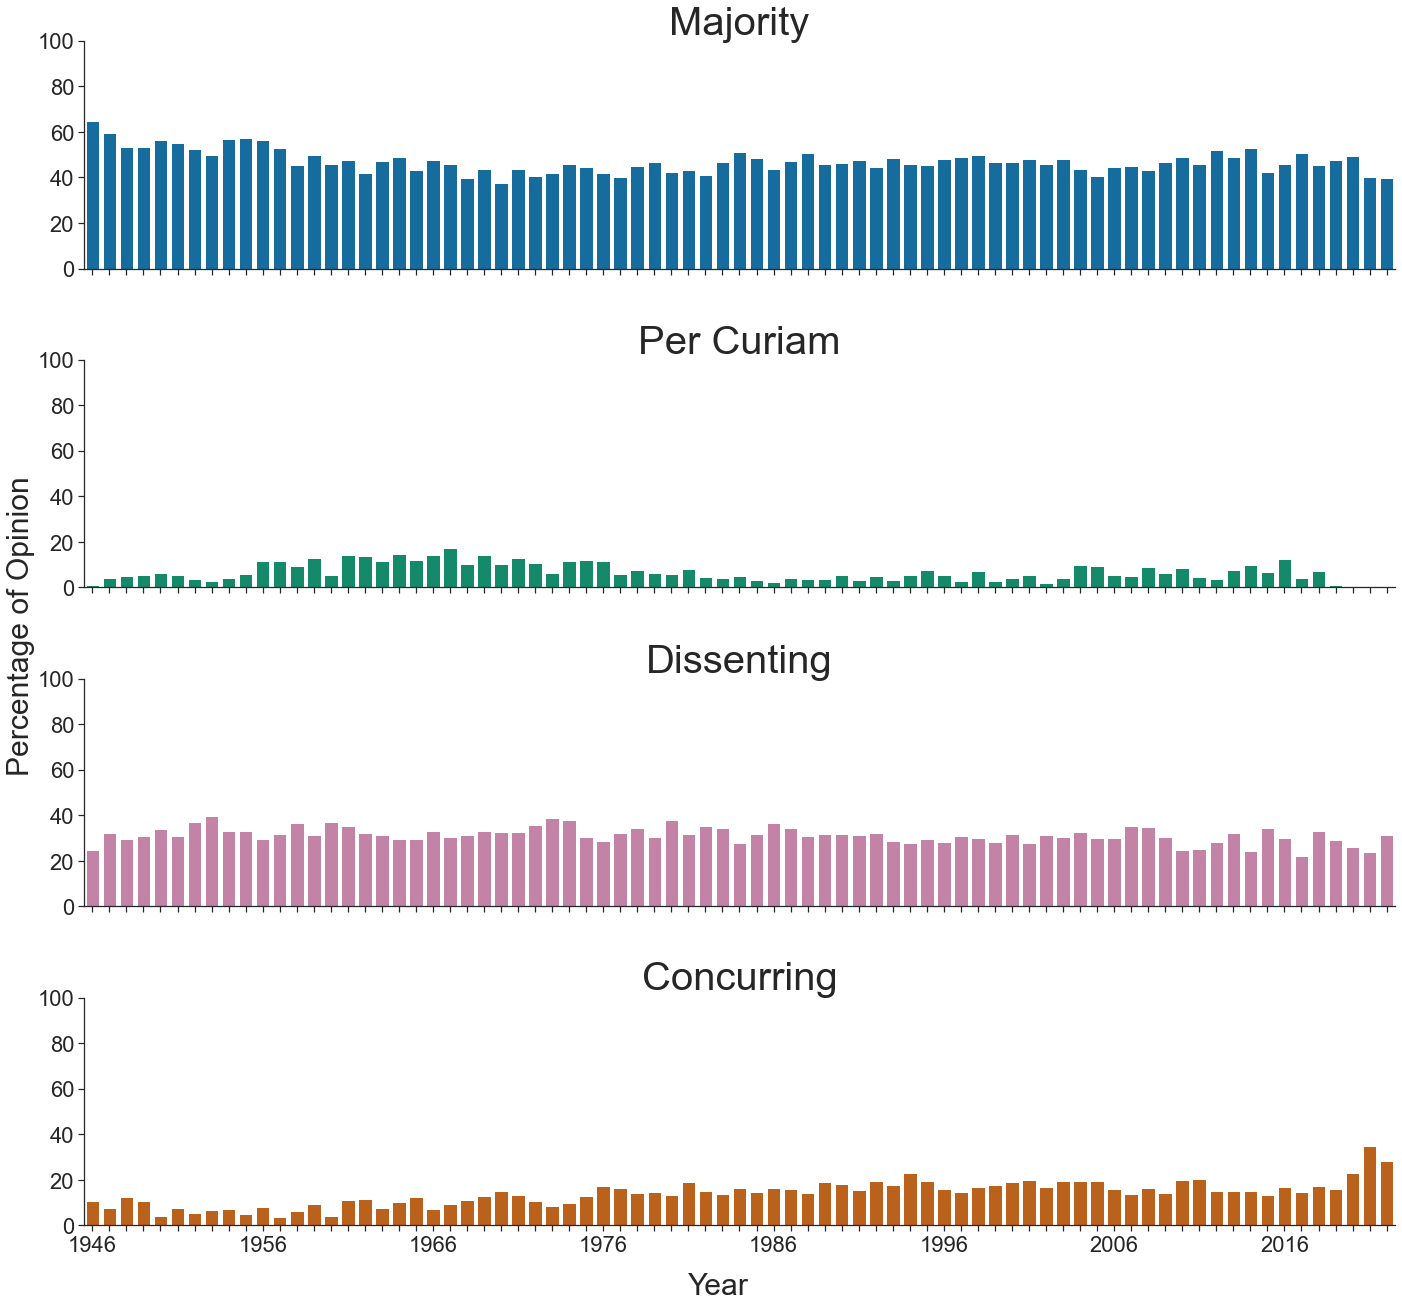

In [36]:
sns.set_palette(sns.color_palette("colorblind"))
colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 


g = sns.FacetGrid(full_counts_by_year, 
                  col="category", 
                  col_wrap=1, 
                  hue = "category", 
                  height=5,
                  aspect=4,
                  col_order = ["Majority","Per Curiam", "Dissenting", "Concurring"],
                  palette=palette)
g.map(sns.barplot, "year", "percentage")
g.set_titles(col_template="{col_name}", size = 40)


for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%10 == 0): 
            labels[i] = l 
        else:
            labels[i] = ''# skip even labels
    ax.set_xticklabels(labels) # set new labels
    

g.set_axis_labels("", "")
g.set(ylim=(0, 100))
g.fig.subplots_adjust(top=0.88)

plt.text(35, -30, 'Year', fontsize = 30)
plt.text(-5, 200, 'Percentage of Opinion', rotation=90,  fontsize = 30)
plt.subplots_adjust(hspace=0.4)
plt.savefig(output_path + '/count_over_time', dpi = 300)

## Overall z-scores

In [37]:
# drop error names
per_curiam = ["per_curiam", "Justice Vinson"]
df_filtered = df[~df['author'].isin(per_curiam)]
df_filtered = df_filtered.drop(df_filtered[(df_filtered['author'] == "Justice Jackson") & (df_filtered['year'] == 1964)].index)

# get monologic ratio for each opinion
opinion_means = pd.DataFrame(df_filtered.groupby(['opinion_num', 'category','author', 'case', 'year'])['monologic_prediction'].mean()).reset_index()

zscore = lambda x: (x - x.mean()) / x.std()

# group by opinion category and find z scores
opinion_means.insert(1, 'z-score', opinion_means.groupby(['category'])['monologic_prediction'].transform(zscore))

author_mean = pd.DataFrame(opinion_means.groupby('author')['z-score'].mean())

In [38]:
opinion_means[opinion_means["case"] =="AT&T Mobility LLC v. Concepcion"]

,opinion_num,z-score,category,author,case,year,monologic_prediction
2254,2535,-0.358637,Majority,Justice Scalia,AT&T Mobility LLC v. Concepcion,2011,0.125683
2255,2536,-0.931417,Concurring,Justice Thomas,AT&T Mobility LLC v. Concepcion,2011,0.158730
2256,2537,-0.299907,Dissenting,Justice Breyer,AT&T Mobility LLC v. Concepcion,2011,0.203008


# Monologic Voice By Author
Group by author, then category, and find mean of monologic prediction


In [39]:
grouped_df = pd.DataFrame(opinion_means.groupby(["author", "category"])["monologic_prediction"].mean())
grouped_df = grouped_df.reset_index(level=['category'])
author_by_category = pd.pivot_table(data=grouped_df,index=['author'], columns = ["category"], values = ["monologic_prediction"])

new_grouped_df = author_by_category.monologic_prediction.copy(["Majority", "Dissenting", "Concurring"])

author_overall_category_mean = author_mean.merge(author_by_category, left_index=True, right_index=True, how='inner')

author_overall_category_mean = author_overall_category_mean.reset_index()

author_overall_category_mean.author.replace("Justice ",'',regex=True, inplace = True)

author_overall_category_mean = author_overall_category_mean.set_index("author")

author_overall_category_mean = author_overall_category_mean.sort_values(by=['z-score'], ascending=False)

/Users/rosamondthalken/opt/anaconda3/envs/3350/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


In [40]:
author_overall_category_mean = author_overall_category_mean.drop(['z-score'], axis=1)

In [41]:
def plot_heatmap_by_category(df):
    sns.set(style='ticks', font_scale=2)
    plt.subplots(figsize=(15,20)) 
    mask = df.isnull()
    column_labels = ["Concurring", "Dissenting", "Majority"]
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, reverse=True)
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                xticklabels=column_labels,
                cmap = "Blues"
               )
    graph.set_facecolor('lightgrey')
    plt.ylabel(' ')
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/by_justice', dpi = 300)
    plt.show()

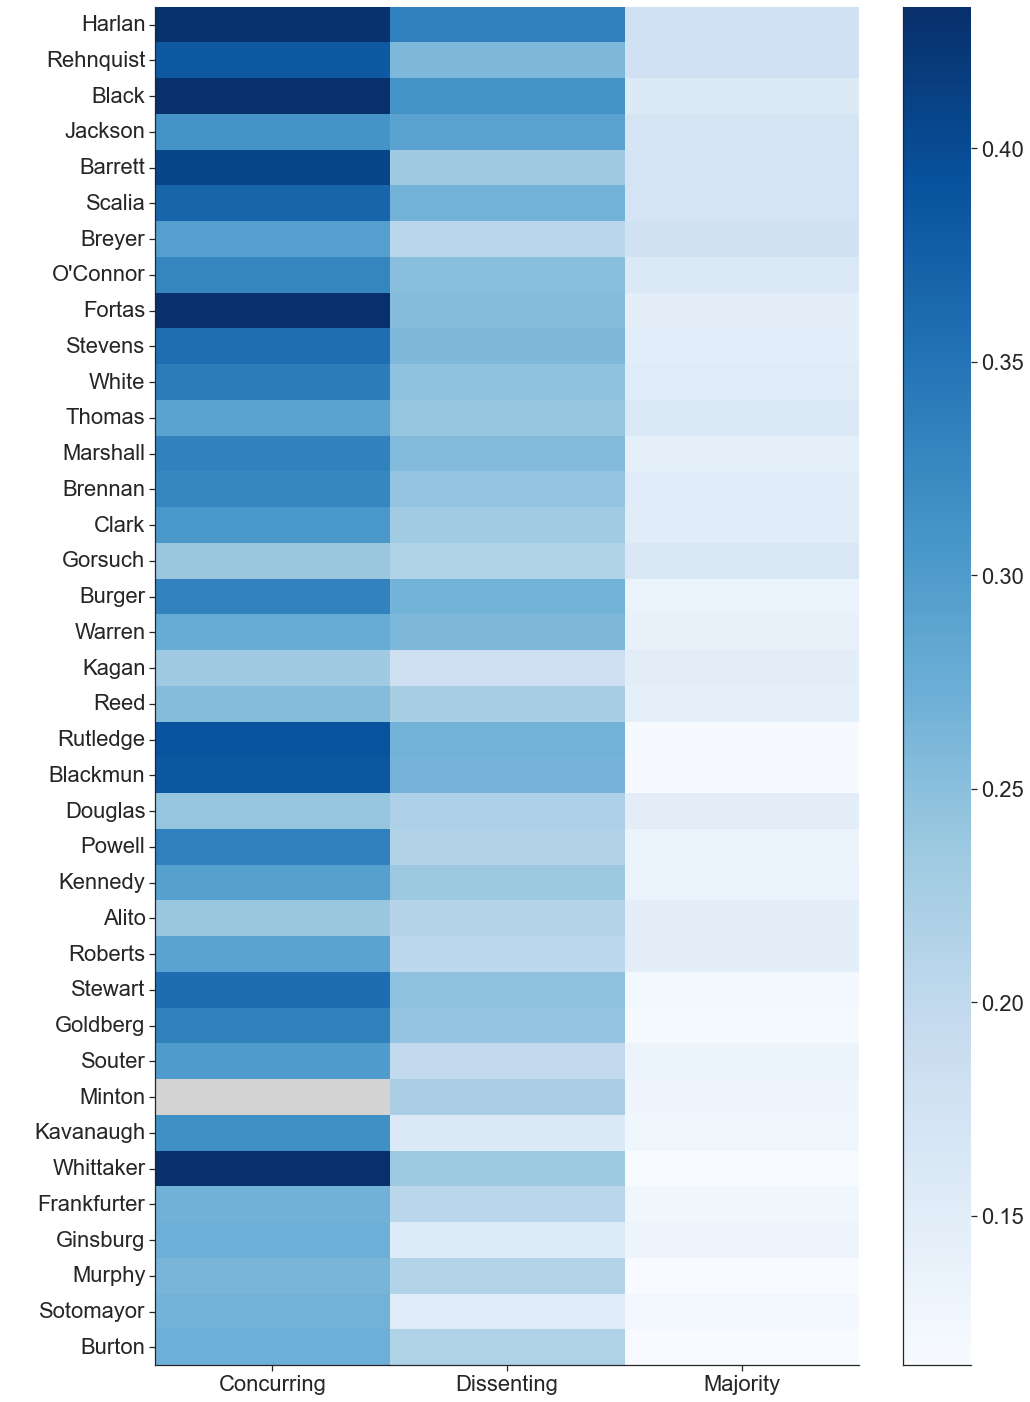

In [42]:
plot_heatmap_by_category(author_overall_category_mean)

In [43]:
df_filtered["majority_class"] = np.where(df_filtered["category"] == "Majority", True, False)

In [44]:
# combine minority & majority opinions for each justice
author_maj_min = df_filtered.groupby(["author", "majority_class"])["monologic_prediction"].mean()
author_maj_min = pd.DataFrame(author_maj_min)

author_maj_min = author_maj_min.reset_index()

# want to change this so that index is author, columns are True and False, data is monologic prediction
author_maj_min = pd.pivot_table(author_maj_min, values='monologic_prediction', index=['author'],
                    columns=['majority_class'])

author_maj_min.reset_index(inplace=True, level = ['author'])

author_maj_min = author_maj_min.rename(columns = {False:"Minority", True: "Majority"})

author_maj_min.author.replace("Justice ",'',regex=True, inplace = True)

roberts_court = pd.DataFrame(["Stevens", "O'Connor", "Scalia", "Kennedy", "Souter", "Thomas", "Ginsburg", "Breyer", "Roberts", "Alito", "Sotomayor", "Kagan", "Gorsuch", "Kavanaugh", "Barrett" ])
roberts_court["roberts_justice"] = "Roberts Court"

roberts_court = roberts_court.rename(columns = {0:"author"})
author_maj_min = author_maj_min.merge(roberts_court, on = "author", how = "outer")
author_maj_min = author_maj_min.fillna("Not Roberts Court")

In [45]:
def scatter_justices_contrast_cols(df, majority_col, minority_col, hue_col, style_col):
    plt.figure(figsize=(20,15))
    palette ={"Roberts Court": "#008080", "Not Roberts Court":"#bc8f8f"} 


    g = sns.scatterplot(data=df, 
                    x=majority_col, 
                    y=minority_col, 
                    s = 400, 
                    hue = hue_col, 
                    style = style_col,
                    palette = palette)

    for i in range(author_maj_min.shape[0]):
        plt.text(x=author_maj_min.Majority[i]+.0009,y=author_maj_min.Minority[i],s=author_maj_min.author[i], 
              fontdict=dict(color='black',size=20))
    
    point1 = [.01, .01]
    point2 = [.275, .275]

    x_values = [point1[0], point2[0]]

    y_values = [point1[1], point2[1]]
    
    plt.plot(x_values, y_values, linestyle = '--', color = 'grey')

    plt.xlabel("Collective Voice Fraction")
    plt.ylabel("Individualistic Voice Fraction")

    legend = plt.legend(loc='upper left', title='')


    plt.xlim(.09, .30)
    plt.ylim(.09, .30)
    
    
    plt.savefig(output_path + '/by_justice_scatter', dpi = 300);

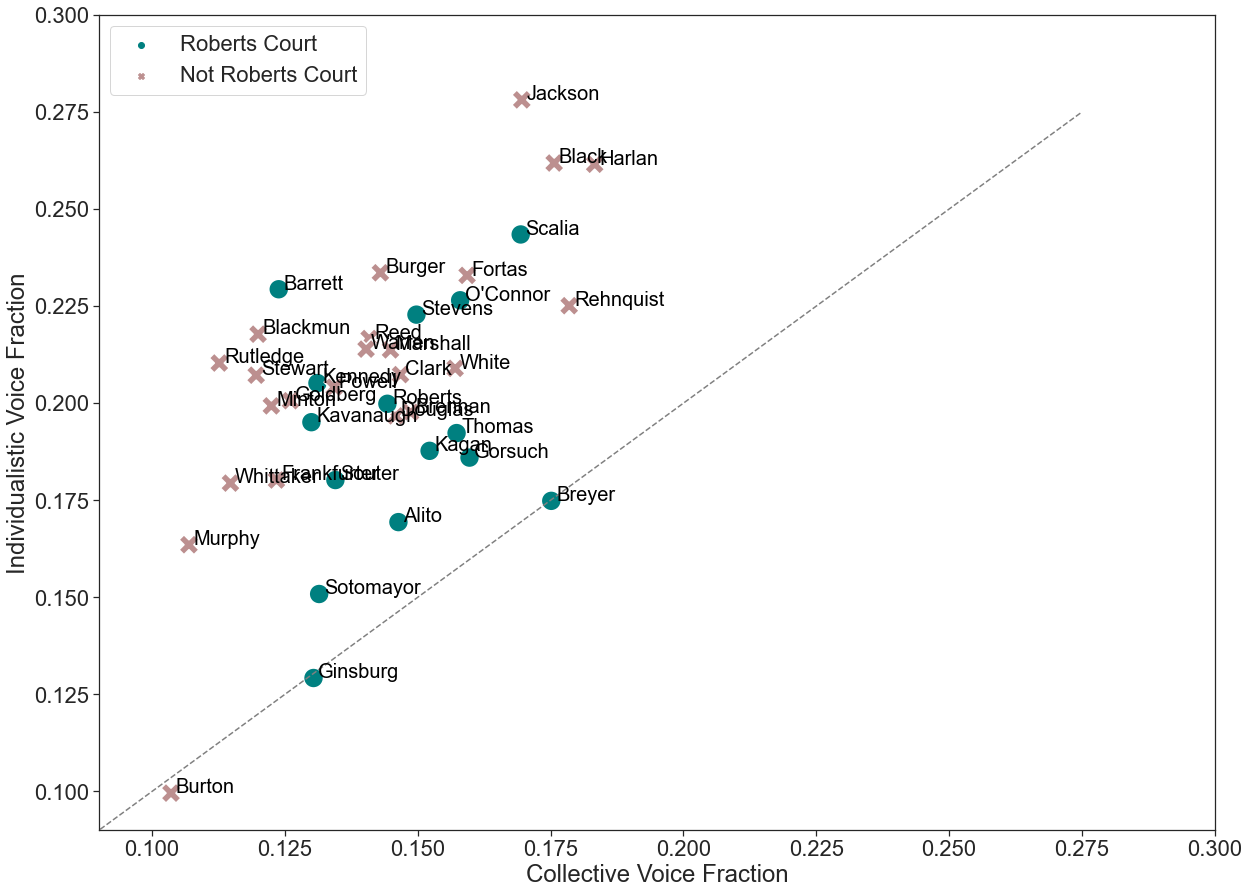

In [46]:
scatter_justices_contrast_cols(author_maj_min, "Majority", "Minority", "roberts_justice", "roberts_justice")

## z-score by year

In [47]:
opinion_means.author.replace("Justice ",'',regex=True, inplace = True)
grouped_year = pd.DataFrame(opinion_means.groupby(['author', 'year'])['z-score'].mean())
grouped_year_df = grouped_year.reset_index(level=['year'])
author_by_year = pd.pivot_table(data=grouped_year_df,index=['author'], columns = ["year"], values = ["z-score"])

In [48]:
# Get (decent) order for waterfall/california effect - silly, but relatively easy

author_by_year = author_by_year.sort_values(by = ('z-score', 2020), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2018), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2017), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2015), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2013), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2010), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2007), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2005), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2003), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 2000), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1999), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1998), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1997), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1996), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1995), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1994), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1993), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1992), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1991), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1990), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1987), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1985), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1982), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1980), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1977), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1975), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1973), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1970), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1969), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1968), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1967), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1966), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1965), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1963), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1960), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1957), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1955), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1953), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1950), ascending=False, na_position='last')
author_by_year = author_by_year.sort_values(by = ('z-score', 1946), ascending=False, na_position='last')

In [49]:
def plot_heatmap_by_year(df, include_cj = False):
    sns.set(style='ticks', font_scale=1.7)
    plt.subplots(figsize=(20,15)) 

    # if include_cj:
    #     chief_years = [0, 6, 22, 41, 60]
    #     chief_names = ["Vinson", "Warren", "Burger", "Rehnquist", "Roberts"]
    #     for year, n in zip(chief_years, chief_names):
    #     plt.axvline(year, color='darkgrey')
    #     plt.text(x=year+.5, y=36.5, s=n, color='dimgrey')

    mask = df.isnull()
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                cmap = sns.cubehelix_palette(rot=-.4)
               )
    graph.set_facecolor('gainsboro')
    plt.xticks(np.arange(-1, 76, 10),
               ['1945', '1955', '1965', '1975', '1985', '1995', '2005', '2015'], 
               rotation = 360,
               fontsize = 20
              )
    plt.xlabel('Year')
    plt.ylabel('')
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/heatmap_over_time', dpi = 300)
    plt.show()

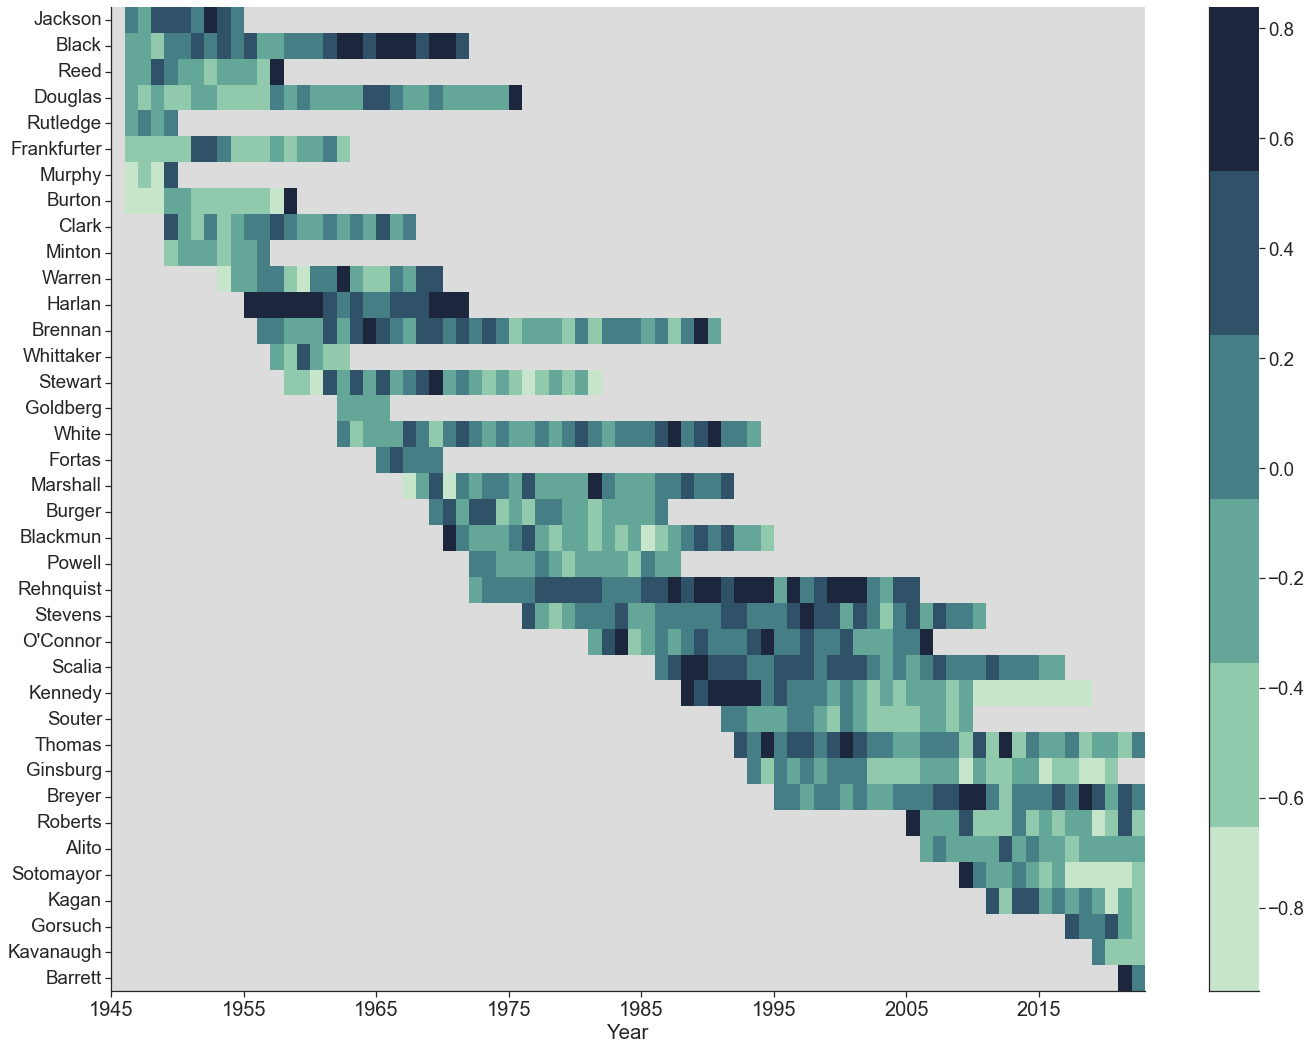

In [50]:
plot_heatmap_by_year(author_by_year)

# Fightin words

In [11]:
def combine_text(df):
    text_df = df.groupby('opinion_num', as_index = False).agg({'text': ' '.join})
    metadata = df[["opinion_num","category", "author", "case", "year", "monologic_prediction"]].copy()
    metadata = metadata.drop_duplicates()
    full_df = pd.merge(metadata, text_df, on="opinion_num")
    
    return full_df

In [12]:
monologic_df = df[df["prob_1"] > .90]
non_monologic_df = df[df["prob_0"] > .90]
monologic_text = combine_text(monologic_df)
non_monologic_text = combine_text(non_monologic_df)

In [13]:
# Monologic to non-monologic
monologic_list = monologic_text.text.tolist()
non_monologic_list = non_monologic_text.text.tolist()

In [54]:
# dissenting_monologic = monologic_text[monologic_text["category"] == "Dissenting"]
# concurring_monologic = monologic_text[monologic_text["category"] == "Concurring"]
# majority_monologic = monologic_text[monologic_text["category"] == "Majority"]
# per_curiam_monologic = monologic_text[monologic_text["category"] == "Per Curiam"]

# dissenting_text = dissenting_monologic.text.tolist()
# concurring_text = concurring_monologic.text.tolist()
# dissenting_concurring_text = dissenting_text + concurring_text

# majority_text = majority_monologic.text.tolist()
# per_curiam_text = per_curiam_monologic.text.tolist()
# majority_per_curiam_text = majority_text + per_curiam_text

In [55]:
# df["majority_class"] = np.where((df["category"] == "Majority")|(df["category"] == "Per Curiam"), True, False)

In [56]:
# majority_class = df[df["majority_class"] == True]
# minority_class = df[df["majority_class"] == False]

In [57]:
# majority_class_text = majority_class.text.tolist()
# minority_class_text = minority_class.text.tolist()

In [14]:
# change these based on which classes are being compared

list1 = monologic_list
list2 = non_monologic_list

In [15]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

remove_from_stops = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves','he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']

stopwords_best = [token for token in stopwords if token not in remove_from_stops]
print(stopwords_best)

['it', "it's", 'its', 'itself', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 

In [16]:
import string
exclude = set(string.punctuation)
from sklearn.feature_extraction.text import CountVectorizer as CV

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    return_string = ''.join([char for char in in_string if ord(char) < 128 and char not in exclude]).lower()
    return_string = ' '.join([word for word in return_string.split() if word not in stopwords_best])
    return return_string

def bayes_compare_language(l1, l2, output_path, ngram=1, prior=.01, cv=None, sig_val=2.573):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]

    if cv is None:
        cv = CV(
            decode_error = 'ignore', 
            min_df = 10, 
            max_df = .9, 
            ngram_range=(1,ngram),
            binary = False,
            max_features = 1500)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v: k for k, v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = [(index_to_term[i], z_scores[i]) for i in sorted_indices]
    

    # plotting z scores and frequencies
    x_vals = count_matrix.sum(axis=0)
    y_vals = z_scores
    sizes = abs(z_scores) * 2
    neg_color, pos_color, insig_color = ('#340509', '#053430', '#d8d8d8')
    colors = []
    annots = []
    for i, y in enumerate(y_vals):
        if y > sig_val:
            colors.append(pos_color)
            annots.append(index_to_term[i])
        elif y < -sig_val:
            colors.append(neg_color)
            annots.append(index_to_term[i])
        else:
            colors.append(insig_color)
            annots.append(None)

    
    fig, ax = plt.subplots(figsize=(14,20))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0, alpha = 0.4)

    for i, annot in enumerate(annots):
        if annot is not None:
            if (np.abs(y_vals[i]) > 2.573) & (np.abs(y_vals[i]) < 10):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.2)
            if (np.abs(y_vals[i]) >= 10) & (np.abs(y_vals[i]) < 20):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.5)
            if (np.abs(y_vals[i]) >= 20) & (np.abs(y_vals[i]) < 40):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.7)
            if (np.abs(y_vals[i]) >= 40):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12, alpha = 0.9)

    ax.set_xscale('log')
    plt.xlabel("Word Frequency")
    plt.ylabel("z-score (log scale)")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(output_path, 'fightin_words.png'), dpi = 300)

    return return_list, cv.vocabulary_

Vocab size is 1500
Comparing language...


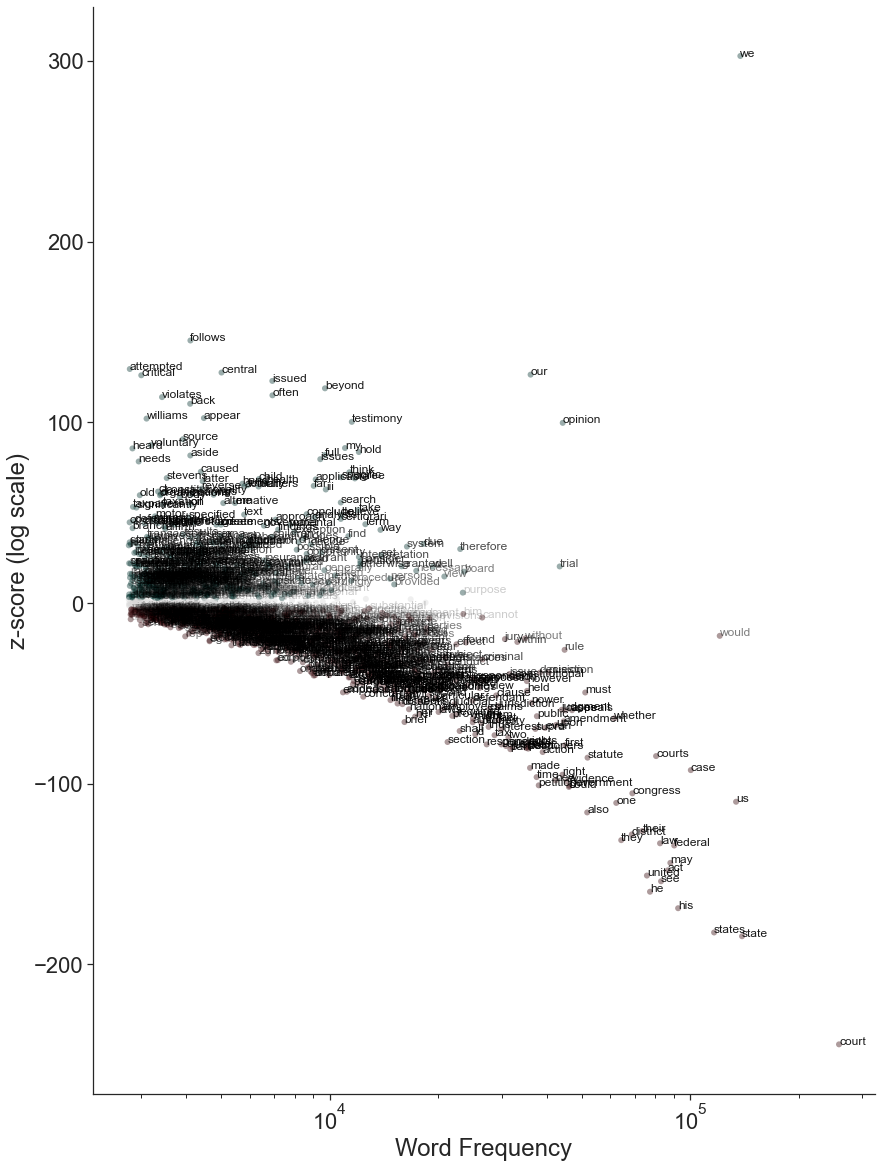

In [18]:
# setting max df very low, given that a document is a sentence
vectorizer = CV(decode_error = 'ignore', max_df = .9, min_df = .005, binary = False, max_features = 1500)  

vector = vectorizer.fit_transform(list1 + list2)

vector_prior = np.sum(vector, axis=0).astype(int)

vector_prior = np.squeeze(np.asarray(vector_prior))

output_list, vocabulary = bayes_compare_language(list1, list2, output_path, prior=vector_prior, cv=vectorizer)
z_scores_df = pd.DataFrame(output_list)



In [22]:
', '.join(z_scores_df.head(60)[0].tolist())

'court, state, states, his, he, see, united, act, may, federal, law, they, district, their, also, one, us, congress, could, government, petitioner, evidence, new, time, right, case, made, statute, courts, action, part, petitioners, claim, justice, order, use, first, respondents, general, rights, section, two, tax, id, shall, interest, supra, even, thus, upon, property, authority, brief, amendment, fact, might, whether, them, her, public'

In [21]:
', '.join(z_scores_df.sort_values(by = 1, ascending=False).head(60)[0].tolist())

'we, follows, attempted, central, our, critical, issued, beyond, often, violates, back, appear, williams, testimony, opinion, source, voluntary, my, heard, hold, full, aside, issues, needs, caused, think, specific, stevens, agree, child, applicable, latter, health, hand, turn, far, actually, matters, reverse, iii, ct, constitutionality, double, hearings, war, old, organizations, body, search, me, alternative, oil, taxation, taxpayers, significantly, take, conclude, text, believe, motor'

In [104]:
z_scores_df.to_csv(os.path.join(output_path, 'z_scores_fightin_words.csv'))


## Comparing Monologic Prediction w/ Personal Pronouns

In [53]:
def find_personal_pronouns(string):
    regex = re.compile(r'\bWE\b | \bI\b | \bUS\b | \bOUR\b| \bMY\b| \bME\b', flags=re.I | re.X)
    response = regex.findall(string)
    pronoun_presence = bool(response)
    
    # could also return "response" if actually want pronoun
    return pronoun_presence

In [54]:
df["personal_pronoun"] = df["text"].apply(find_personal_pronouns)

In [55]:
df.loc[((df['personal_pronoun'] == True) & (df['monologic_prediction'] == 1)), 'monologic_pronoun_align'] = "True"
df.loc[((df['personal_pronoun'] == False) & (df['monologic_prediction'] == 0)), 'monologic_pronoun_align'] = "True"

df.loc[((df['personal_pronoun'] == True) & (df['monologic_prediction'] == 0)), 'monologic_pronoun_align'] = "False"
df.loc[((df['personal_pronoun'] == False) & (df['monologic_prediction'] == 1)), 'monologic_pronoun_align'] = "False"

In [56]:
text_counter = Counter()
text_counter.update(df["monologic_pronoun_align"])
text_counter = dict(text_counter)

In [57]:
counted_matches = pd.DataFrame.from_dict(text_counter, orient='index').reset_index()
counted_matches

,index,0
0,True,1456996
1,False,71160


In [58]:
all_match = counted_matches.iloc[0][0]
all_mismatch = counted_matches.iloc[1][0]
all_match / (all_match + all_mismatch)*100

95.34340734846442

In [59]:
mono_df = df[df["monologic_prediction"] == 1]

In [60]:
mono_counter = Counter()
mono_counter.update(mono_df["monologic_pronoun_align"])
mono_counter = dict(mono_counter)

In [61]:
mono_matches = pd.DataFrame.from_dict(mono_counter, orient='index').reset_index()
mono_matches

,index,0
0,False,30695
1,True,225885


In [62]:
mono_match = mono_matches.iloc[0][0]
mono_mismatch = mono_matches.iloc[1][0]
mono_match / (mono_match + mono_mismatch)*100

11.963130407670123

In [63]:
non_mono_df = df[df["monologic_prediction"] == 0]
non_mono_counter = Counter()
non_mono_counter.update(non_mono_df["monologic_pronoun_align"])
non_mono_counter = dict(non_mono_counter)
non_mono_matches = pd.DataFrame.from_dict(non_mono_counter, orient='index').reset_index()
non_mono_matches

,index,0
0,True,1231111
1,False,40465


In [64]:
non_mono_match = non_mono_matches.iloc[0][0]
non_mono_mismatch = non_mono_matches.iloc[1][0]

non_mono_match / (non_mono_match + non_mono_mismatch)*100

96.81772855102643

In [65]:
pronoun_df = df[df["personal_pronoun"] == True]

In [66]:
mismatch_pronoun = pd.DataFrame(pronoun_df[pronoun_df["monologic_pronoun_align"] == "False"])

In [67]:
mismatch_pronoun["text"].sample(5).to_list()

['4 It is not unreasonable to expect a States highest legal officer to know the States law and to bring to this Courts attention the rules of state law that might affect the sound exercise of our discretion to grant certiorari, or that might demonstrate that we granted the writ improvidently.',
 'In order to maintain such an action, the State must articulate an interest apart from the interests of particular private parties, i. e., the State must be more than a nominal party.',
 'This case presents two questions: (1) "whether the filing of a motion to reopen removal proceedings automatically tolls the period within which an alien must depart... under an order granting voluntary departure," Brief for Petitioner i, and (2) "whether an alien who has been granted voluntary departure and has filed a timely motion to reopen should be permitted to withdraw the request for voluntary departure prior to the expiration of the departure period," 552 U.S. ___, 128 S. Ct. 1116, 169 L. Ed.',
 'In rul

In [68]:
no_pronoun_df = df[df["personal_pronoun"] == False]

In [69]:
mismatch_without_pronoun = no_pronoun_df[no_pronoun_df["monologic_pronoun_align"] == "False"]

In [70]:
mismatch_without_pronoun["text"].sample(5).to_list()

['As the Court recognizes, ante, at 342, n. 37, state statutes authorizing the issuance of moratoria often limit the moratorias duration.',
 'Without disagreeing about the similarity of the two organizations, the majority nonetheless distinguished National Right to Work on the ground of its addressing regulation of contributions, not expenditures.',
 'The rule that the Court has crafted creates the opposite incentive.',
 'Courts every day see reasonable defenses that ultimately fail (just as they see reasonable claims that come to nothing); in this context, as in any other, they are capable of distinguishing between those defenses (or claims) and the objectively unreasonable variety.',
 'But the Court’s argument does not follow.']

# Most monologic opinions

In [71]:
df_short_opinion = df[df["length"]<=20]

In [72]:
short_opinion_mean = df_short_opinion.groupby(["opinion_num", "case", "category", "year", "author", "length"])["monologic_prediction"].mean()

In [73]:
df_long_opinion = df[df["length"] >20]

In [74]:
opinion_mean = df_long_opinion.groupby(["opinion_num", "case", "category", "year", "author", "length"])["monologic_prediction"].mean()

In [75]:
opinion_mean_df = pd.DataFrame(opinion_mean)

In [76]:
pd.set_option('display.max_rows', 500)

In [77]:
opinion_mean_df.to_csv("opinion_monologic_rating.csv")

In [78]:
opinion_mean_df.sort_values(by=['monologic_prediction'], ascending=False).head(50)

,,,,,,monologic_prediction
opinion_num,case,category,year,author,length,
3520,Mishkin v. New York,Dissenting,1966,Justice Black,21,0.809524
11735,John R. Sand & Gravel Co. v. United States,Dissenting,2008,Justice Stevens,30,0.739130
14954,Donovan v. Dewey,Concurring,1981,Justice Stevens,26,0.727273
6767,Nixon v. Fitzgerald,Dissenting,1982,Justice Blackmun,21,0.722222
5575,Whalen v. United States,Concurring,1980,Justice White,38,0.709677
13950,Dixon v. Duffy,Dissenting,1952,Justice Jackson,21,0.700000
1684,Bloom v. Illinois,Concurring,1968,Justice Fortas,33,0.687500
4077,Czyzewski v. Jevic Holding Corp.,Dissenting,2017,Justice Thomas,21,0.684211
5663,Georgia v. McCollum,Concurring,1992,Justice Rehnquist,47,0.682927


Rutledge, Concurring, *Commissioner v. Tower*:
>"I agree with the result and with the Court's view that the evidence was amply sufficient to sustain the Tax Court's findings and conclusions in this case and in Lusthaus v. Commissioner, post, p. 327 U. S. 293. Candor forces me to add, however, that, in my judgment, the decisions' effect is to rule that, in situations of this character, the formation of a limited partnership under state law between husband and wife, with the latter as the limited partner, following immediately upon the husband's donation to the wife of a share in the assets of the business previously and afterwards conducted by him and conditioned upon her leaving the assets in the business, as a matter of federal tax law does not accomplish the formation of a partnership sufficient to relieve the husband of tax liability for the income derived after the transfer from use in the business of the share thus donated to the wife. In other words, I think that, as a matter of law, the taxpayers in these cases were liable for the taxes assessed against them, including the deficiency assessments, and therefore, in my opinion, the Tax Court is not free in these or substantially similar circumstances to draw either the contrary conclusion or opposing ones. While it is not strictly necessary to express this opinion in these cases in view of the Tax Court's consistent conclusions of liability, it is inconceivable to me that the two cases, consistently with the federal tax law, could be decided the other way, or with different outcomes on the facts presented. Being of this opinion, I consider the failure to state it could only tend to perpetuate a source of possible confusion for the future." 

Brennan, Concurring, *Maynard v. Cartwright*:
>"I join the Court's opinion except insofar as the judgment, which is without prejudice to further sentencing proceedings, does not expressly preclude the reimposition of the death penalty. Adhering to my view that the death penalty is in all circumstances cruel and unusual punishment prohibited by the Eighth and Fourteenth Amendments, Gregg v. Georgia, 428 U. S. 153, 428 U. S. 227, 428 U. S. 231 (1976), I would direct that the resentencing proceedings be circumscribed such that the State may not reimpose the death sentence." 

Marshall, Dissenting, *Harris v. Rivera*:
> "I write separately to underscore my disapproval of what I perceive to be a growing and inexplicable readiness on the part of this Court to "dispose of" cases summarily. Perhaps this trend is due to what is often lamented as our "increasing caseload." Whatever the reason for this trend, I believe that it can only detract from this Court's decisions in deserving cases by consuming time and energy better spent elsewhere. 

> Moreover, by deciding cases summarily, without benefit of oral argument and full briefing, and often with only limited access to, and review of, the record, this Court runs a great risk of rendering erroneous or ill-advised decisions that may confuse the lower courts: there is no reason to believe that this Court is immune from making mistakes, particularly under these kinds of circumstances. As Justice Jackson so aptly put it, although in a somewhat different context: "We are not final because we are infallible, but we are infallible only because we are final." Brown v. Allen, 344 U. S. 443, 344 U. S. 540 (1953) (concurring in result). I believe that this Court should reserve its final imprimatur for those cases to which we give plenary review, after full briefing and argument.

> This is not to say that I believe that summary disposition is never appropriate. In my view, however, this Court should utilize this practice with more caution than has been true in the recent past." 

Breyer, Concurring, *Greenlaw v. United States*
>"I agree with Justice Alito that the cross-appeal requirement is simply a rule of practice for appellate courts, rather than a limitation on their power, and I therefore join Parts I–III of his opinion. Moreover, as a general matter, I would leave application of the rule to the courts of appeals, with our power to review their discretion “seldom to be called into action.” Universal Camera Corp. v. NLRB, 340 U. S. 474, 490 (1951). But since this case is now before us, I would consider whether the Court of Appeals here acted properly. Primarily for the reasons stated by the majority in footnote 9 of its opinion, I believe that the court abused its discretion in sU. S.onte increasing petitioner’s sentence. Our precedent precludes the creation of an exception to the cross-appeal requirement based solely on the obviousness of the lower court’s error. See, e.g., Chittenden v. Brewster, 2 Wall. 191, 195–196 (1865). And I cannot see how the interests of justice are significantly disserved by permitting petitioner’s release from prison at roughly age 62, after almost 37 years behind bars, as opposed to age 77."


**LONGER**
Black, Dissenting, *Mishkin v. New York*
>"The Court here affirms convictions and prison sentences aggregating three years plus fines totaling /12,000 imposed on appellant Mishkin based on state charges that he hired others to prepare and publish obscene books and that Mishkin himself possessed such books. This Court has held in many cases that the Fourteenth Amendment makes the First applicable to the States. See, for illustration, cases collected in my concurring opinion in Speiser v. Randall, 357 U. S. 513, 357 U. S. 530. Consequently, upon the same grounds that I dissented from a five-year federal sentence imposed upon Ginzburg in 383 U. S. 383 U.S. 476 for sending "obscene" printed matter through the United States mails, I dissent from affirmance of this three-year state sentence imposed on Mishkin. Neither in this case nor in Ginzburg have I read the alleged obscene matter. This is because I believe, for reasons stated in my dissent in Ginzburg and in many other prior cases, that this Court is without constitutional power to censor speech or press regardless of the particular subject discussed. I think the federal judiciary, because it is appointed for life, is the most appropriate tribunal that could be selected to interpret the Constitution, and thereby mark the boundaries of what government agencies can and cannot do. But because of life tenure, as well as other reasons, the federal judiciary is the least appropriate branch of government to take over censorship responsibilities by deciding what pictures and writings people throughout the land can be permitted to see and read. When this Court makes particularized rules on what people can see and read, it determines which policies are reasonable and right, thereby performing the classical function of legislative bodies directly responsible to the people. Accordingly, I wish once more to express my objections to saddling this Court with the irksome and inevitably unpopular and unwholesome task of finally deciding by a case-by-case, sight-by-sight personal judgment of the members of this Court what pornography (whatever that means) is too hard core for peopleto see or read. If censorship of views about sex or any other subject is constitutional, then I am reluctantly compelled to say that I believe the tedious, time-consuming and unwelcome responsibility for finally deciding what particular discussions or opinions must be suppressed in this country should, for the good of this Court and of the Nation, be vested in some governmental institution or institutions other than this Court.

>I would reverse these convictions. The three-year sentence imposed on Mishkin and the five-year sentence imposed on Ginzburg for expressing views about sex are minor in comparison with those more lengthy sentences that are inexorably bound to follow in state and federal courts as pressures and prejudices increase and grow more powerful, which of course they will. Nor is it a sufficient answer to these assuredly ever-increasing punishments to rely on this Court's power to strike down "cruel and unusual punishments" under the Eighth Amendment. Distorting or stretching that Amendment by reading it as granting unreviewable power to this Court to perform the legislative function of fixing punishments for all state and national offenses offers a sadly inadequate solution to the multitudinous problems generated by what I consider to be the un-American policy of censoring the thoughts and opinions of people. The only practical answer to these concededly almost unanswerable problems is, I think, for this Court to decline to act as a national board of censors over speech and press, but instead to stick to its clearly authorized constitutional duty to adjudicate cases over things and conduct. Halfway censorship methods, no matter how laudably motivated, cannot, in my judgment, protect our cherished First Amendment freedoms from the destructive aggressions of both state and national government. I would reverse this case and announce that the First and Fourteenth Amendments, taken together, command that neither Congress nor the States shall pass laws which in any manner abridge freedom of speech and press -- whatever the subjects discussed. I think the Founders of our Nation, in adopting the First Amendment, meant precisely that the Federal Government should pass "no law" regulating speech and press, but should confine its legislation to the regulation of conduct. So too, that policy of the First Amendment, made applicable to the States by the Fourteenth, leaves the States vast power to regulate conduct, but no power at all, in my judgment, to make the expression of views a crime.

In [79]:
case_mean = df_long_opinion.groupby(["case", "year"])["monologic_prediction"].mean()
case_length = df_long_opinion.groupby(["case", "year"])["length"].sum()
case_mean_df = pd.DataFrame(case_mean)
case_length_df = pd.DataFrame(case_length)
case_length_mean_df = pd.merge(case_length_df, case_mean_df, on = ["case", "year"])
case_num = case_length_mean_df.groupby(["case", "year"]).count()

In [80]:
case_length_mean_df.sort_values(by=['monologic_prediction'], ascending=False).head(10)

,,length,monologic_prediction
case,year,,
Zatko v. California,1991,783,0.592593
Mintzes v. Buchanon,1985,2700,0.560000
Carter v. West Feliciana Parish School Bd.,1970,650,0.560000
Truesdale v. Aiken,1987,783,0.555556
Dixon v. Duffy,1952,1505,0.549020
Retirement Plans Comm. of IBM v. Jander,2019,399,0.526316
Martin v. District of Columbia Court of Appeals,1992,928,0.517241
"Whitaker v. Superior Court of Cal., San Francisco Cty.",1995,440,0.500000
Maleng v. Cook,1989,2900,0.480000


In [81]:
case_length_mean_df.to_csv("case_monologic_rating.csv")

## Correlation Between Monologic Voice and Ideology

In [82]:
author_mean.head()

,z-score
author,
Justice Alito,-0.174348
Justice Barrett,0.265966
Justice Black,0.308578
Justice Blackmun,-0.134680
Justice Brennan,0.012177


In [83]:
martin_quinn_mean = pd.DataFrame(martin_quinn.groupby(["justiceName"])["post_mn"].mean())
scd_list_names = list(martin_quinn_mean.index)
author_mean = author_mean.reset_index()

In [84]:
# create justice matcher
def match_scd_author(df_col):
    if df_col == "Justice O'Connor":
        scd_name = "SDOConnor"
    elif df_col == "Justice Black":
        scd_name = "HLBlack"
    elif df_col == "Justice Roberts":
        scd_name = "JGRoberts"
    else:
        match = re.search(r'Justice (\S+)', df_col)
        last_name = match.group(1)
        name = list(filter(lambda x: last_name in x, scd_list_names))
        scd_name = ''.join(name)

    return scd_name

In [85]:
author_mean["scd_name"] = author_mean.apply(lambda row: match_scd_author(row["author"]),axis=1)

In [86]:
author_mean

,author,z-score,scd_name
0,Justice Alito,-0.174348,SAAlito
1,Justice Barrett,0.265966,
2,Justice Black,0.308578,HLBlack
3,Justice Blackmun,-0.134680,HABlackmun
4,Justice Brennan,0.012177,WJBrennan
5,Justice Breyer,0.135012,SGBreyer
6,Justice Burger,-0.076782,WEBurger
7,Justice Burton,-0.506653,HHBurton
8,Justice Clark,-0.006673,TCClark
9,Justice Douglas,-0.147008,WODouglas


In [87]:
# merge df and martin_quinn_ave
martin_quinn_mean = martin_quinn_mean.reset_index()
justice_monologic_ideology = author_mean.merge(martin_quinn_mean, left_on = "scd_name", right_on = "justiceName")

In [88]:
monologic_array = justice_monologic_ideology["z-score"].array
ideology_array = justice_monologic_ideology["post_mn"].array
corr, _ = pearsonr(monologic_array, ideology_array)
print(corr)

0.22979018907624824


### By year

In [89]:
author_by_year = df.groupby(['author', 'year', 'chief_justice'], as_index=False)['monologic_prediction'].mean()
author_by_year = author_by_year[author_by_year["author"] != "per_curiam"]
author_by_year["scd_name"] = author_by_year.apply(lambda row: match_scd_author(row["author"]),axis=1)
author_by_year = author_by_year[author_by_year["scd_name"] != ""]

year_monologic_ideology = pd.merge(author_by_year, martin_quinn,  how='left', left_on=['scd_name','year'], right_on = ['justiceName','term'])
# index_names = year_monologic_ideology[year_monologic_ideology['author'] == "per_curiam"].index
  
# # drop these row indexes
# year_monologic_ideology = year_monologic_ideology.drop(index_names, inplace = True)
# year_monologic_ideology = year_monologic_ideology.dropna()

monologic_years_array = year_monologic_ideology["monologic_prediction"].values.reshape(-1, 1)
year_ideology_array = year_monologic_ideology["post_mn"].values.reshape(-1, 1)

In [90]:
year_monologic_ideology = year_monologic_ideology.dropna()

In [91]:
corr_ideology_year = pearsonr(year_monologic_ideology["monologic_prediction"].array, year_monologic_ideology["post_mn"].array)
print(corr_ideology_year)

(0.0872175242742592, 0.025380284279307302)


### By court

In [92]:
year_monologic_ideology.groupby('chief_justice')[['monologic_prediction','post_mn']].corr()

monologic_prediction   post_mn
chief_justice                                                     
Burger        monologic_prediction              1.000000 -0.000920
              post_mn                          -0.000920  1.000000
Rehnquist     monologic_prediction              1.000000  0.338600
              post_mn                           0.338600  1.000000
Roberts       monologic_prediction              1.000000  0.197098
              post_mn                           0.197098  1.000000
Vinson        monologic_prediction              1.000000 -0.024148
              post_mn                          -0.024148  1.000000
Warren        monologic_prediction              1.000000 -0.084840
              post_mn                          -0.084840  1.000000

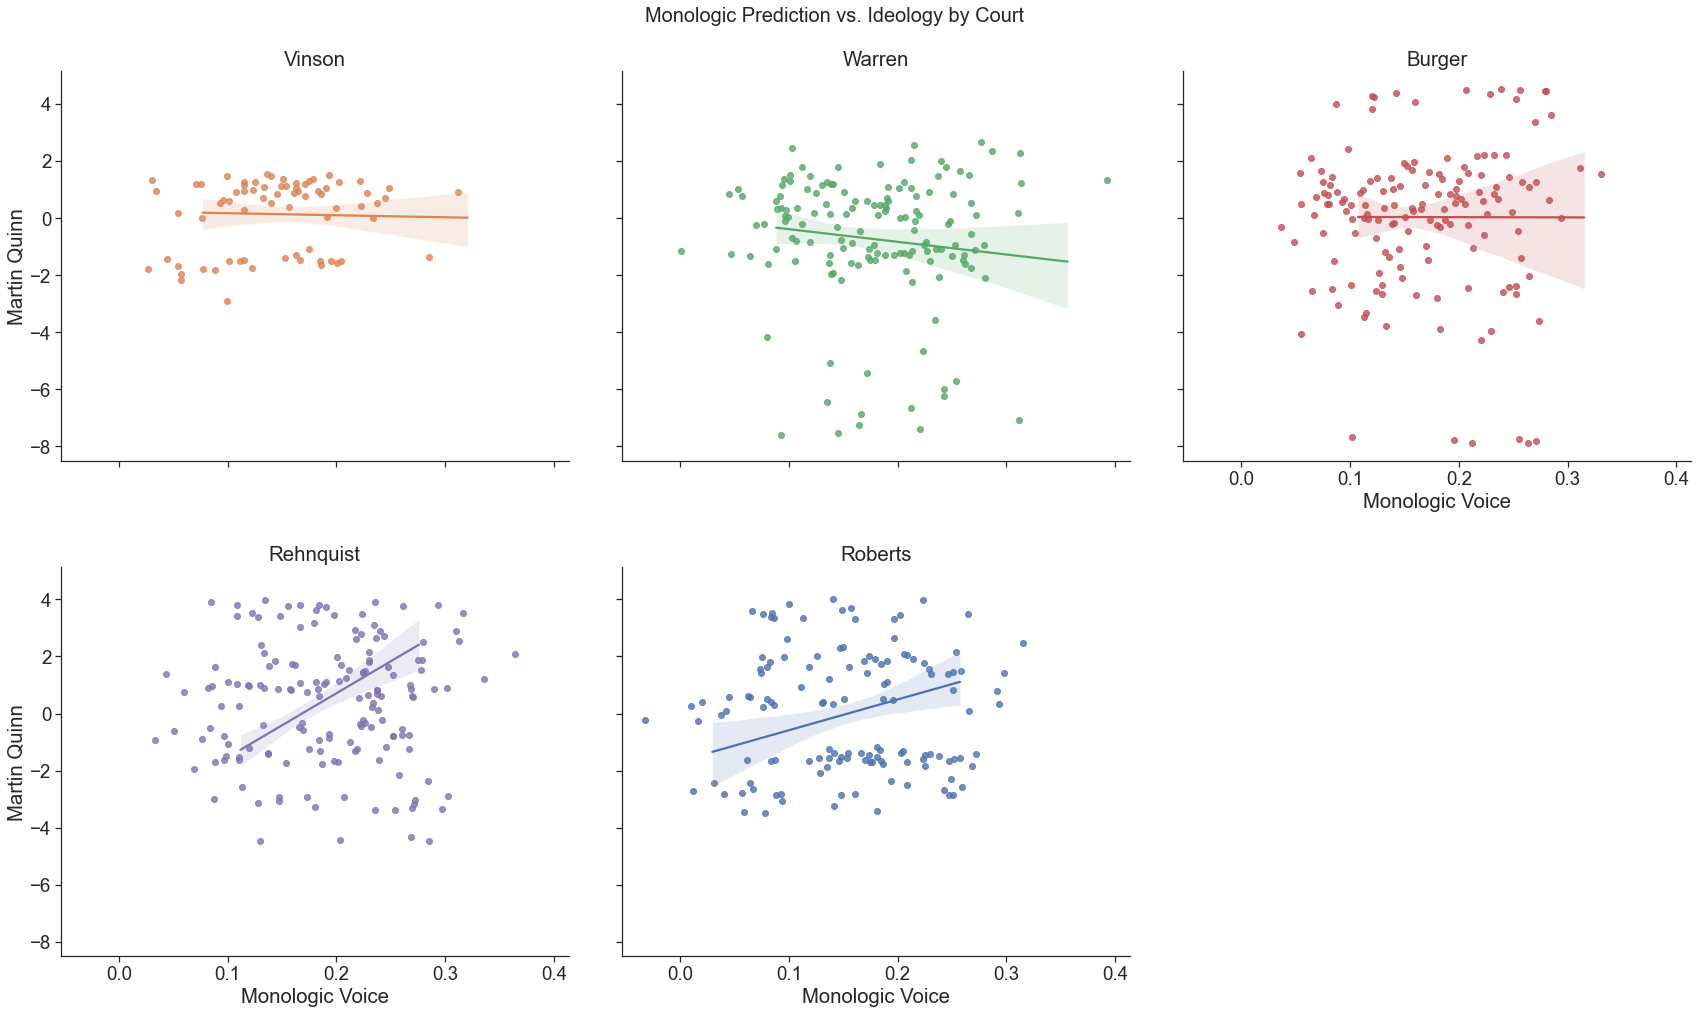

In [93]:
g = sns.lmplot(x="monologic_prediction", 
               y="post_mn", 
               hue="chief_justice", 
               col="chief_justice", 
               col_wrap=3,
               col_order=["Vinson", "Warren", "Burger", "Rehnquist", "Roberts"],
               data=year_monologic_ideology, 
               #height=6, 
               #aspect=, 
               x_jitter=.1)

g.set_titles(col_template="{col_name}")
g.set(xlabel='Monologic Voice', ylabel='Martin Quinn')
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Monologic Prediction vs. Ideology by Court', fontsize = 20)
g.fig.set_figheight(15)
g.fig.set_figwidth(25)

## Salience

In [94]:
opinion_monologic = df.groupby(['case', 'chief_justice'], as_index=False)['monologic_prediction'].mean()
df_for_merging = salience_df[['case_name', 'salience.est', 'nytSalience', 'cqSalience']]
df_for_merging = df_for_merging.drop_duplicates()
salience_monologic_opinion = opinion_monologic.merge(df_for_merging, left_on = "case", right_on = "case_name")

opinion_monologic_array = salience_monologic_opinion.monologic_prediction.values.reshape(-1, 1)
opinion_salience_array = salience_monologic_opinion["salience.est"].values.reshape(-1, 1)

salience_monologic_opinion = salience_monologic_opinion[["monologic_prediction","nytSalience", "cqSalience"]]

### Salience and monologic voice - t-test

In [95]:
# get all opinions that are from non-salient cases
non_salient_group = salience_monologic_opinion[salience_monologic_opinion['nytSalience'] == 0]['monologic_prediction']

# get all opinions that are from salient cases
salient_group = salience_monologic_opinion[salience_monologic_opinion['nytSalience'] == 1]['monologic_prediction']

import scipy.stats as stats
print(stats.ttest_ind(non_salient_group, salient_group))

Ttest_indResult(statistic=-4.35374571075375, pvalue=1.3580159248590626e-05)


In [96]:
import researchpy as rp

rp.ttest(non_salient_group, salient_group)

(               Variable       N      Mean        SD        SE  95% Conf.  \
 0  monologic_prediction  5872.0  0.169744  0.074849  0.000977   0.167829   
 1  monologic_prediction   899.0  0.181143  0.060450  0.002016   0.177186   
 2              combined  6771.0  0.171258  0.073199  0.000890   0.169514   
 
    Interval  
 0  0.171659  
 1  0.185100  
 2  0.173001  ,
                                             Independent t-test    results
 0  Difference (monologic_prediction - monologic_prediction) =     -0.0114
 1                                        Degrees of freedom =   6769.0000
 2                                                         t =     -4.3537
 3                                     Two side test p value =      0.0000
 4                                    Difference < 0 p value =      0.0000
 5                                    Difference > 0 p value =      1.0000
 6                                                 Cohen's d =     -0.1559
 7                           

## Seniority

In [97]:
# get lowest year for each Justice
first_year_df = pd.DataFrame(df.groupby("author")["year"].min())
first_year_df = first_year_df.reset_index()
monologic_senior_year = author_by_year.merge(first_year_df, on = "author")
monologic_senior_year["year_on_court"] = monologic_senior_year["year_x"] - monologic_senior_year["year_y"]
monologic_senior_year = monologic_senior_year[monologic_senior_year["author"] != "per_curiam"]

/Users/rosamondthalken/opt/anaconda3/envs/3350/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rosamondthalken/opt/anaconda3/envs/3350/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


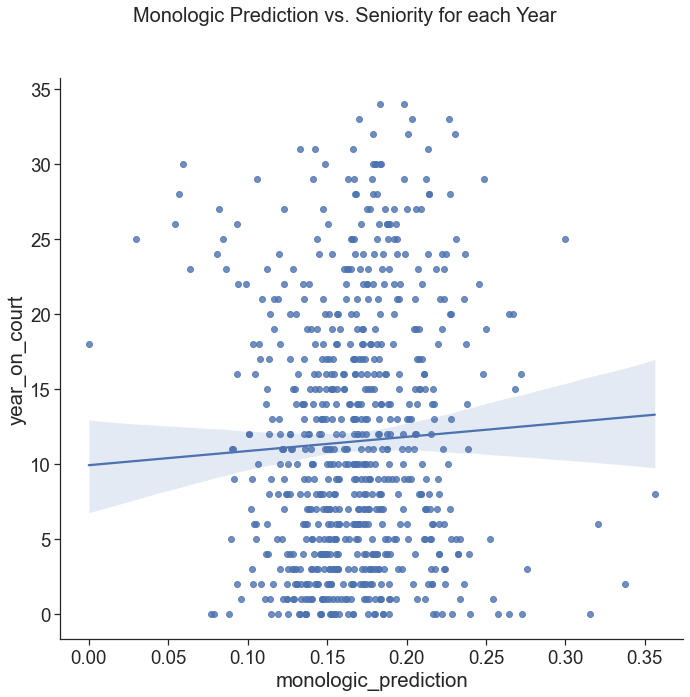

In [98]:

g = sns.lmplot('monologic_prediction', 'year_on_court', data=monologic_senior_year, height = 10, fit_reg=True, legend_out=True)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Monologic Prediction vs. Seniority for each Year', fontsize = 20)

plt.show()

In [99]:
corr = pearsonr(monologic_senior_year["monologic_prediction"].array, monologic_senior_year["year_on_court"].array)
print(corr)

(0.04368574679103622, 0.2453472281540846)
